скачивем библиотеки

In [6]:
!pip install pandas

импортируем их

In [7]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import r2_score
import re
import tkinter as tk
from tkinter import scrolledtext

загружаем данные

In [8]:
expenses = pd.read_csv('expenses_new.csv')
orders = pd.read_csv('orders_new.csv')
segmented_rfm = pd.read_csv('segmented_rfm.csv')
user_data = pd.read_csv('user_data.csv')
visitation = pd.read_csv('visitation_new.csv')

# 4.1 Предсказание целевой переменной

### модель обуч

быстро обучем модель как было сделанно раньше

In [9]:
# Напишем функцию, которая принимает на вход DataFrame, кодирует числовыми значениями категориальные признаки
# и возвращает обновленный DataFrame и сами кодировщики.
def number_encode_features(init_df):
    result = init_df.copy() # копируем нашу исходную таблицу
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == object: # np.object -- строковый тип / если тип столбца - строка, то нужно его закодировать
            encoders[column] = preprocessing.LabelEncoder() # для колонки column создаем кодировщик
            result[column] = encoders[column].fit_transform(result[column]) # применяем кодировщик к столбцу и перезаписываем столбец
    return result, encoders

encoded_data, encoders = number_encode_features(user_data) # Теперь encoded data содержит закодированные кат. признаки
encoded_data.head()


,User Id,Region,Device,Channel,Revenue,costs
0,981449118918,0,3,5,4.99,6.24
1,278965908054,0,3,5,4.99,5.04
2,590706206550,0,1,5,4.99,6.96
3,326433527971,0,0,3,4.99,9.36
4,349773784594,0,1,5,4.99,11.04


In [10]:
X = encoded_data.drop('Channel', axis=1)
y = encoded_data['Channel']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
model = make_pipeline(StandardScaler(), SVC())

In [13]:
model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()), ('svc', SVC())])

## предсказание

Данный код способен выдавать результаты r2 и сохранять все прогнозы в файл csv

In [14]:
# X_test - контрольная выборка атрибутов
# y_test - контрольная выборка целевой переменной

# Прогнозирование для контрольной выборки
y_pred = model.predict(X_test)

# Оценка качества модели с помощью коэффициента детерминации (R2)
r2 = r2_score(y_test, y_pred)
print(f"Коэффициент детерминации (R2) на контрольной выборке: {r2}")

# Запись ответов, содержащих соответствующие атрибуты и предсказания целевой переменной, в файл
results = pd.DataFrame(list(zip(X_test, y_test,y_pred)), columns=['атрибуты', 'реальные_значения','предсказанные_значения'])
results.to_csv('результаты_прогнозирования.csv', index=False)

Коэффициент детерминации (R2) на контрольной выборке: -0.7978300523390642


качество у модели не очень результат ~0.8

# 4.2 Разработка прикладного решения

Данный бот реагирует на комманды получить_модель и справка 

In [26]:
df = results

# Пример команд и их действий
commands = {
    "получить_модель": None,
    "справка": None,
}


def execute_command(command, params):
    if command == "получить_модель":
        description = params["Модель"]
        try:
            recipient = description
            return f"Модель найдена: {recipient}"
        except IndexError:
            return "модель не найден"
    
    elif command == "справка":
        return "Справка по командам: получить_модель, справка"
    
    else:
        return "Неизвестная команда"

def process_user_input():
    user_input = input_entry.get()
    if user_input.lower() == "выход":
        root.destroy()
    else:
        command = parse_command(user_input)
        if command:
            params = extract_params(user_input, command)
            result = execute_command(command, params)
            output_text.insert(tk.END, f"\nПользователь: {user_input}\nБот: {result}\n")
            output_text.yview(tk.END)
        else:
            output_text.insert(tk.END, f"\nПользователь: {user_input}\nБот: Не удалось распознать команду\n")
            output_text.yview(tk.END)

def parse_command(text):
    # Пример парсинга команды по ключевым словам с использованием регулярных выражений
    if "получить модель" in text:
        return "получить_модель"
    elif "справка" in text:
        return "справка"
    else:
        return None

def extract_params(text, command):
    # Пример извлечения параметров из текста команды
    params = {}
    if command == "получить_модель":
        match = re.search(r"получить_модель (.+)", text)
        if match:
            params["Модель"] = match.group(1)
    return params

# Создание графического интерфейса с использованием Tkinter
root = tk.Tk()
root.title("Бот")

# Создание текстового поля для вывода результата
output_text = scrolledtext.ScrolledText(root, height=20, width=50)
output_text.pack()

# Создание поля для ввода команды
input_entry = tk.Entry(root, width=50)
input_entry.pack()

# Создание кнопки "Отправить"
send_button = tk.Button(root, text="Отправить", command=process_user_input)
send_button.pack()

root.mainloop()

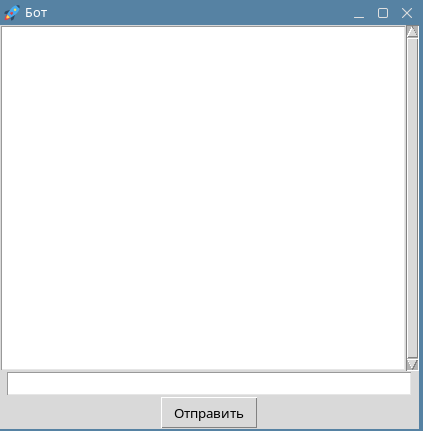

Вот так выглядить его интерфейс есть кнопка отправить и поле ввода и скролл

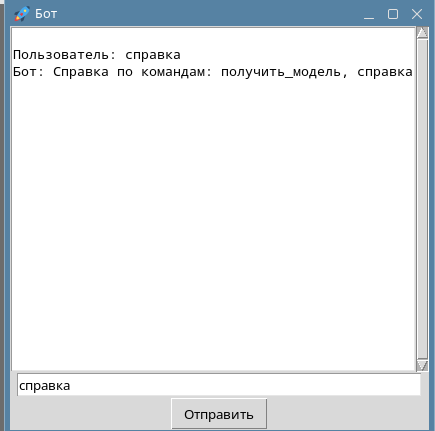

Вот реакция на комманду справка

# 4.3 Подготовка отчета

В результате данного модуля были выполнены почти все задачи 

4.1 Предсказание целевой переменной
- Было выполнено прогнозирование для контрольной выборки с
помощью полученной модели. Определено качество модели на контрольной
выборке с помощью коэффициента детерминации (R2). Записаны ответы,
содержащие соответствующие атрибуты и предсказания целевой переменной,
в файл.Результаты r2 ~0.8

4.2 Разработка прикладного решения
- Был разработан программный интерфейс для итоговой модели машинного
обучения. API приложению позволяет пользователям получать доступ к
модели регрессии для прогнозирования расходов на привлечение клиентов.
Разработано приложение с графическим интерфейсом, которое c
помощью разработанного API генерировать прогнозы по новым данным в
режиме реального времени.
Приложение предоставляет справку по имеющимся командам и их
параметрам.

4.3 Подготовка отчета
- Был подготовлен отчет о проделанной работе по итогам сессии, в котором
представлены результаты, выводы и обоснования выбора по каждому разделу
задания. Результаты работы состоят из отчетов в форматах: .ipynb и
.html, а также исходников с возможностью перекомпиляции. Архив Data.zip
содержит все результаты выполнения модуля, а также все необходимые
файлы для запуска и проверки участков кода. В файле Readme.txt
описано содержимое результирующих файлов архива Data.zip.